# Initial condition inversion in advective-diffusive transport

In this notebook, we consider a time-dependent advection-diffusion equation in which we invert for an unknown initial condition.

Let $\Omega \subset \mathbb{R}^n$ (here we take $n=2$) be open and bounded and we are given state observations taken on a part $\Gamma_m \subset \partial \Omega$ over the time $[T_1, T]$ with $0 < T_1 < T$.
The inverse problem is formulated as:

$$
\min_{m} J(m) := \frac{1}{2}\int_{T_1}^{T} \int_{\Gamma_m} (u-u_d)^2\, dx dt +
\frac{\gamma_1}{2}\int_\Omega m^2\,dx +
\frac{\gamma_2}{2}\int_\Omega |\nabla m|^2\,dx,
$$

where $u$ is the solution of
$$
\begin{align}
\frac{\partial u}{\partial t} - \kappa\Delta u+ \mathbf{v} \cdot \nabla u&= 0 \quad \text{ in }\left[0,T\right]\times\Omega,\\
\kappa\frac{\partial u}{\partial n}&=0\quad \text{ in }\left[0,T\right]\times\partial\Omega,\\
u(0,\mathbf{x})&=m(\mathbf{x})\quad \text{ in }\Omega\cup\partial\Omega.
\end{align}
$$

Here, $u_d$ denotes measurements on $\Gamma_m$, $\gamma_1$ and $\gamma_2$ are regularization parameters corresponding to $L^2$- and $H^1$-regularizations, respectively, and $\kappa > 0$ is the diffusion coefficient. The advection velocity $\mathbf{v}$ is computed by solving the following steady state Navier-Stokes equation with the side walls driving the flow:
$$
\begin{aligned}
\frac{1}{\text{Re}} \Delta \mathbf{v} + \nabla q + \mathbf{v} \cdot \nabla \mathbf{v} &= 0 &\quad&\text{ in }\Omega,\\
\nabla \cdot \mathbf{v} &= 0 &&\text{ in }\Omega,\\
\mathbf{v} &= \mathbf{g} &&\text{ on } \partial\Omega.
\end{aligned}
$$
where $q$ is pressure, Re is the Reynolds number, and $\mathbf{g} = (g_1, g_2)^T = \mathbf{0}$ on $\partial \Omega$ but $g_1 = 1$ on the left boundary and $g_2 = -1$ on the right boundary.

### Discretization of the forward problem

The weak form of the forward problem reads: Find $u \in \mathcal{V}$ such that
$$
\int_0^T \int_\Omega \left(\frac{\partial u}{\partial t} p + \kappa \nabla u \cdot \nabla p + 
\mathbf{v} \cdot \nabla u p \right) dx dt
+ \int_\Omega (u(0,\mathbf{x}) - m) p_0 dx = 0; \quad \forall p \in \mathcal{V}
$$
where $\mathcal{V} := \{v \in H^1(\Omega), \text{for each } t \in (0, T)\}$.
Finite element discretization of the above weak form results in
$$
\mathbf{M} \dot{\mathbf{u}}(t) + \{\kappa \mathbf{K} + \mathbf{B}\} \mathbf{u} (t) = \mathbf{0}
$$
where $\mathbf{u}(t)$ is the finite element coefficient for $u$ at time $t$, and $\mathbf{M}$, $\mathbf{K}$, and $\mathbf{B}$ are the corresponding matrix forms of the time derivative, diffusitive, and advective terms in the weak form.

The implicit (backward) Euler time discretization with time step $\Delta t$ leads to
$$
\mathbf{M} \mathbf{u}\left((i+1) \Delta t\right) - \mathbf{M} \mathbf{u}(i \Delta t) + 
\Delta t\{\kappa \mathbf{K} + \mathbf{B}\} \mathbf{u} \left((i+1) \Delta t \right) = \mathbf{0}; \quad i = 0, \ldots, n_t - 1.
$$
Hence we have
$$
\mathbf{A} \mathbf{u} ((i+1) \Delta t) = \mathbf{M} \mathbf{u} (i \Delta t); \quad i = 0, \ldots, n_t-1
$$
where
$$
\mathbf{A} =  \mathbf{M} + \Delta t\{\kappa \mathbf{K} + \mathbf{B}\}.
$$

### Discretization of the objective function $J(m)$

By term-by-term discretization of the objective function, we have
$$
\int_{T_1}^T (\bar{\mathbf{u}} (t) - \bar{\mathbf{u}}_d (t) )^T \mathbf{M}_{\Gamma_m} 
(\bar{\mathbf{u}} (t) - \bar{\mathbf{u}}_d (t)) dt
+ \frac{\gamma_1}{2} \mathbf{m}^T \mathbf{M}_m \mathbf{m}
+ \frac{\gamma_2}{2} \mathbf{m}^T \mathbf{R} \mathbf{m}
$$
where $\bar{\mathbf{u}}$ and $\bar{\mathbf{u}}_d$ are the finite element coefficients of $u$ and $u_d$, respectively, defined only on the boundary $\Gamma_m$, and $\mathbf{m}$ is the finite element coefficient of $m$. 
The first term of the above equation is further approximated as
$$
\int_{T_1}^T (\bar{\mathbf{u}} (t) - \bar{\mathbf{u}}_d (t) )^T \mathbf{M}_{\Gamma_m} 
(\bar{\mathbf{u}} (t) - \bar{\mathbf{u}}_d (t)) dt
= \sum_{t = t_1}^{n_t \Delta t} (\bar{\mathbf{u}} (t) - \bar{\mathbf{u}}_d (t) )^T \Delta t\mathbf{M}_{\Gamma_m} 
(\bar{\mathbf{u}} (t) - \bar{\mathbf{u}}_d (t))
$$
where $t_1$ is the closest discrete time point to $T_1$.


### Goals:

By the end of this notebook, you should be able to:

- understand the time-dependent inversion method framework
- Newton's method to solve discrete optimality problem
- visualise and understand the results
- modify the problem and code

### Mathematical tools used:

- Finite element method
- Newton's method
- Derivation of gradiant and Hessian via the adjoint method

### 1. Import dependencies

In [1]:
import fenics as dl

import numpy as np
import matplotlib.pyplot as plt
from hippylib import nb
from hippylib import CGSolverSteihaug
import ufl

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

### 2. Set up the model

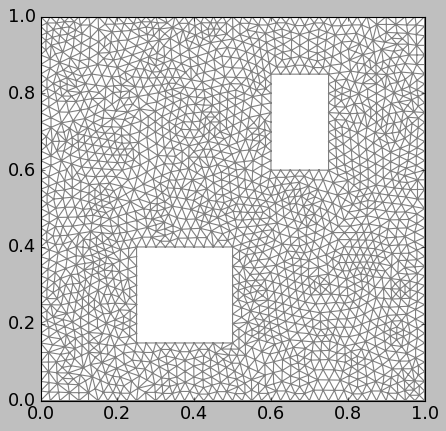

Number of dofs: 2023


In [3]:
# load mesh and define finite element function spaces
mesh = dl.Mesh("ad_20.xml")
mesh = dl.refine(mesh)

dl.plot(mesh)
plt.show()

Vh = dl.FunctionSpace(mesh, "CG", 1)
print("Number of dofs: {}".format(Vh.dim()))

In [4]:
# define the diffusion coefficient field and final time
kappa = 0.001 # diffusion constant
T  = 4    # final time

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.907e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-04)
  Newton iteration 1: r (abs) = 3.482e-02 (tol = 1.000e-10) r (rel) = 1.198e-03 (tol = 1.000e-04)
  Newton iteration 2: r (abs) = 2.086e-06 (tol = 1.000e-10) r (rel) = 7.177e-08 (tol = 1.000e-04)
  Newton solver finished in 2 iterations and 2 linear solver iterations.


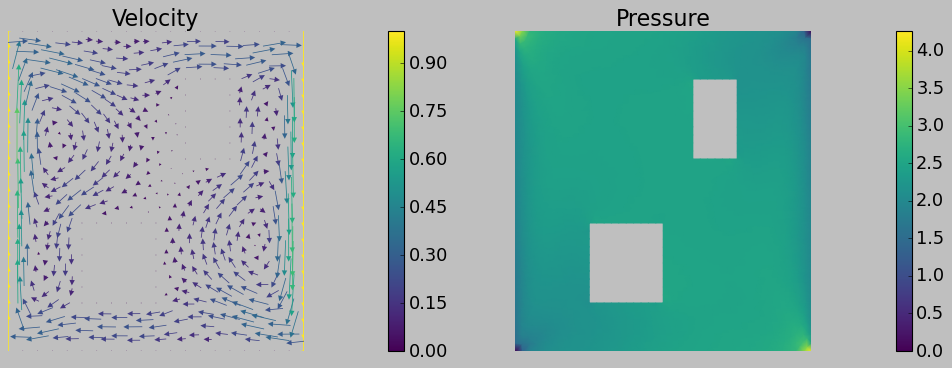

In [5]:
# construct the advection velocity field

def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS

def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
    XW = dl.FunctionSpace(mesh, mixed_element)

    Re = dl.Constant(1e2)

    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    bcs = [bc1, bc2]

    vq = dl.Function(XW)
    (v,q) = ufl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)

    def strain(v):
        return ufl.sym(ufl.grad(v))

    F = ( (2./Re)*ufl.inner(strain(v),strain(v_test))+ ufl.inner (ufl.nabla_grad(v)*v, v_test)
           - (q * ufl.div(v_test)) + ( ufl.div(v) * q_test) ) * ufl.dx

    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})

    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()

    return v

v = computeVelocityField(mesh)

### 3. Define the true parameter field

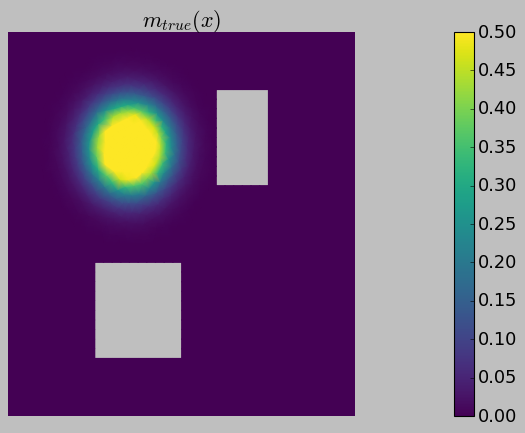

In [6]:
mtrue = dl.interpolate( dl.Expression('std::min(0.5,std::exp(-100*(std::pow(x[0]-0.35,2) +  std::pow(x[1]-0.7,2))))', \
                      element=Vh.ufl_element()), Vh)

nb.plot(mtrue, mytitle=r"$m_{true}(x)$")
plt.show()

### 4. Define the Newton system of the discrete objective function constrained by the advective-diffusive PDE

In [8]:
class reducedHessian:
    def __init__(me, Vh, simulation_times, kappa, v, T1, gamma1, gamma2):
        """
        :param Vh: finite element function space
        :param simulation_times: discretized time points
        :param kappa: diffusion coefficient
        :param v: advection velocity field
        :param T1: starting observation time
        :param gamma1: regularization parameter corresponding to L^2 regularization
        :param gamma2: regularization parameter corresponding to H^1 regularization
        """
        me.nt = len(simulation_times)
        me.dt = simulation_times[1] - simulation_times[0]
        me.Vh = Vh
        me.simulation_times = simulation_times
        me.T1 = T1
        me.gamma1 = gamma1
        me.gamma2 = gamma2
        me.kappa = kappa
        me.v     = v
        utest = dl.TestFunction(Vh)
        utrial = dl.TrialFunction(Vh)
        Kform  = dl.inner(dl.grad(utest), dl.grad(utrial))*dl.dx(me.Vh.mesh())
        Mform  = utest*utrial*dl.dx(me.Vh.mesh())
        Bform  = utest*dl.inner(me.v, dl.grad(utrial))*dl.dx(me.Vh.mesh())
        BTform = utrial*dl.inner(me.v, dl.grad(utest))*dl.dx(me.Vh.mesh())
        Rform  = (gamma1*utest*utrial + gamma2*dl.inner(dl.grad(utest), dl.grad(utrial)))*dl.dx(me.Vh.mesh())
        
        
        me.K = dl.assemble(Kform)
        me.M = dl.assemble(Mform)
        me.B = dl.assemble(Bform)
        me.BT = dl.assemble(BTform)
        me.R = dl.assemble(Rform)
        
     
        me.A     = me.M + me.dt*(me.kappa*me.K + me.B)
        me.A_adj = me.M + me.dt*(me.kappa*me.K + me.BT)
        me.ud = None
        
    def solve_fwd(me, m):
        """
        For given m, solve the forward problem for u
        
        u[0]    = m
        A u[1]  = M u[0]
        ...
        A u[i]  = M u[i]
        ...
        A u[-1] = M u[-2]
        """
        u = [dl.Function(me.Vh) for i in range(me.nt)]
        u[0].assign(m)
        solver = dl.LUSolver()
        solver.set_operator(me.A)
        rhs = dl.Vector()
        me.A.init_vector(rhs, 0)
        for i in range(1, me.nt):
            rhs = me.M * u[i-1].vector()
            solver.solve(u[i].vector(), rhs)
        return u
    
    def solve_adj(me, u):
        """
        For given u, solve the adjoint problem for p
        
        A_adj p[-1] = - dt MGamma (u[-1] - ud[-1])
        A_adj p[-2] = - dt MGamma (u[-2] - ud[-2]) + M p[-1]
        ...
        A_adj p[i]  = - dt MGamma (u[i] - ud[i]) + M p[i+1]
        ...
        A_adj p[j]  = M p[j+1]
        ...
        A_adj p[1]  = M p[2]
        M p[0]      = M p[1]
        """
        p = [dl.Function(me.Vh) for i in range(me.nt)]
        rhs1 = dl.Vector()
        rhs2 = dl.Vector()
        me.M.init_vector(rhs1, 0)
        me.M.init_vector(rhs2, 0)
        solver = dl.LUSolver()
        solver.set_operator(me.A_adj)
        
        for i in range(nt-1, 0, -1):
            if i < nt-1:
                rhs1 = me.M * p[i+1].vector()
            if me.simulation_times[i] > me.T1:
                rhs1 = -1.*me.dt*me.MGamma*(u[i].vector() - me.ud[i].vector())
                if i != nt - 1:
                    rhs2 = me.M * p[i+1].vector()
                    rhs1.axpy(1., rhs2)
            solver.solve(p[i].vector(), rhs1)
        p[0].vector().set_local(p[1].vector())
        return p
    
    def cost(me, m):
        u = me.solve_fwd(m)
        misfit = 0.
        data_discrepancy = dl.Function(me.Vh)
        tempvec = dl.Vector()
        me.MGamma.init_vector(tempvec, 0)
        
        for i, t in enumerate(me.simulation_times):
            if t > me.T1:
                data_discrepancy.assign(u[i])
                data_discrepancy.vector().axpy(-1.0, me.ud[i].vector())
                
                tempvec = me.MGamma*data_discrepancy.vector()
                misfit += 0.5*me.dt*tempvec.inner(data_discrepancy.vector())
        reg = 0.5*m.vector().inner(me.R * m.vector())
        return [misfit+reg, misfit, reg]
    
    def grad(me, m):
        u = me.solve_fwd(m)
        p = me.solve_adj(u)
        MG = dl.Vector()
        me.M.init_vector(MG, 0)
        MG.axpy(1.0, me.R * m.vector())
        MG.axpy(-1.0, me.M * p[0].vector())
        return MG
    
    def solve_incfwd(me, mhat):
        uhat = [dl.Function(me.Vh) for i in range(me.nt)]
        uhat[0].assign(mhat)
        solver = dl.LUSolver()
        solver.set_operator(me.A)
        rhs = dl.Vector()
        me.A.init_vector(rhs, 0)
        for i in range(1, me.nt):
            rhs = me.M * uhat[i-1].vector()
            solver.solve(uhat[i].vector(), rhs)
        return uhat
    
    def solve_incadj(me, uhat):
        phat = [dl.Function(me.Vh) for i in range(me.nt)]
        rhs1 = dl.Vector()
        rhs2 = dl.Vector()
        me.M.init_vector(rhs1, 0)
        me.M.init_vector(rhs2, 0)
        solver = dl.LUSolver()
        solver.set_operator(me.A_adj)
        for i in range(nt-1, 0, -1):
            if i < nt-1:
                rhs1 = me.M * phat[i+1].vector()
            if me.simulation_times[i] > me.T1:
                rhs1 = -1*me.dt*me.MGamma*uhat[i].vector()
                if i != nt-1:
                    rhs2 = me.M * phat[i+1].vector()
                    rhs1.axpy(1., rhs2)
            solver.solve(phat[i].vector(), rhs1)
        phat[0].vector().set_local(phat[1].vector())
        return phat
    
    def init_vector(me, x, j):
        me.M.init_vector(x, j)
        
    def mult(me, x, y):
        mhat = dl.Function(me.Vh)
        mhat.vector().zero()
        mhat.vector().axpy(1.0, x)
        uhat = me.solve_incfwd(mhat)
        phat = me.solve_incadj(uhat)
        y.zero()
        y.axpy(1.0, me.R * x)
        y.axpy(-1.0, me.M * phat[0].vector())
        
    def setup_Gamma_m(me, boundary):
        """
        Construct MGamma, the mass matrix defined over `boundary`.
        
        
        :param boundary: boundary on which the measurement lives
        """
        boundary_markers = dl.MeshFunction("size_t", me.Vh.mesh(), me.Vh.mesh().topology().dim() - 1, 0)
        boundary.mark(boundary_markers, 1)
        ds = dl.Measure("ds", domain=me.Vh.mesh(), subdomain_data=boundary_markers)
        bc_for_dofs = dl.DirichletBC(me.Vh, dl.Constant(0), boundary)
        
        utest = dl.TestFunction(me.Vh)
        utrial = dl.TrialFunction(me.Vh)
        
        # construct the measurement operator
        MGammaform = utest*utrial*ds(1)
        me.MGamma = dl.assemble(MGammaform)
        
        # dofs living on the boundary `boundary`
        me.dofs_Gamma = list(bc_for_dofs.get_boundary_values().keys())

In [45]:
nt = 100
simulation_times = np.linspace(0., T, num=nt)
T1    = 0.4*T
gamma1 = 1.0e-5
gamma2 = 1.0e-6
hess  = reducedHessian(Vh, simulation_times, kappa, v, T1, gamma1, gamma2)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [46]:
# boundary of the two rectangular holes
class HoleBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        left_right = dl.near(x[0], 0) or dl.near(x[0], 1)
        top_bottom = dl.near(x[1], 0) or dl.near(x[1], 1)
        
        return not (left_right or top_bottom) and on_boundary
        
boundary_twoholes = HoleBoundary()
hess.setup_Gamma_m(boundary_twoholes)

### 5. Generate the synthetic measurements

Note that although we save the state measurements over the whole domain in `hess.ud`, only part of it is actually used, i.e., the components of `hess.ud` corresponding to those on the boundary $\Gamma_m$ and at time $t > T_1$.

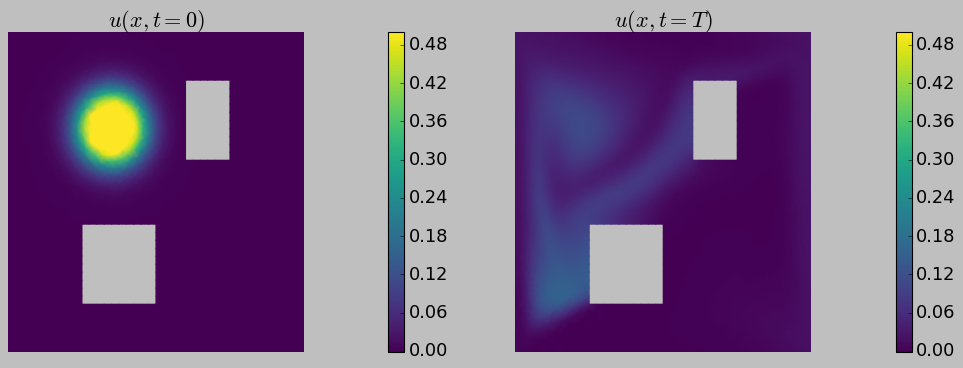

In [47]:
u = hess.solve_fwd(mtrue)
nb.multi1_plot([u[0], u[-1]], [r"$u(x, t=0)$", r"$u(x, t=T)$"])
plt.show()

ud = [dl.Function(Vh) for i in range(nt)]

noise_lvl = 0.02
for i in range(nt):
    ud[i].assign(u[i])
    uL2 = dl.norm(u[i], 'L2')
    noise = noise_lvl * uL2 *np.random.randn(Vh.dim()) 
    ud[i].vector().vec()[:] += noise

hess.ud = ud

### 6. Check the Gradient

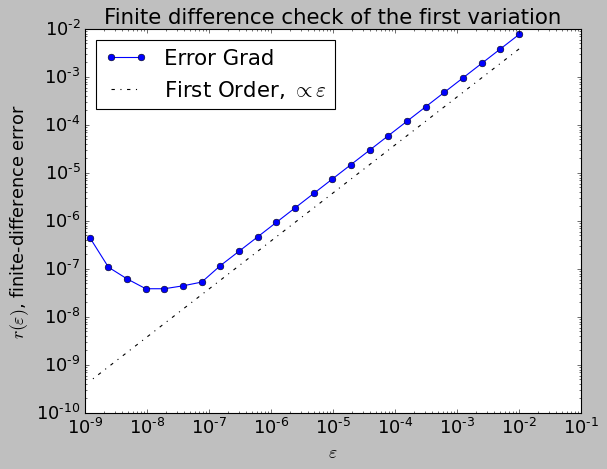

In [48]:
n_eps = 24
eps = 1e-2*np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m0 = dl.interpolate(dl.Expression('1.+std::exp(x[0])*std::cos(pi*x[0])*std::cos(pi*x[1])', \
                                  element=Vh.ufl_element(), pi=np.pi), Vh) 
mdir = dl.interpolate(dl.Expression('std::cos(2.*x[0]*pi)', \
                                   element=Vh.ufl_element(), pi=np.pi), Vh)


J0 = hess.cost(m0)[0]
grad0 = hess.grad(m0)

mh   = dl.Function(Vh)
mhat = dl.Function(Vh).vector()
mhat.set_local(mdir.vector().get_local())

dir_grad0 = grad0.inner(mhat)


for i in range(n_eps):
    mh.assign(m0)
    mh.vector().axpy(eps[i], mhat) #uh = uh + eps[i]*dir
    Jplus = hess.cost(mh)[0]
    err_grad[i] = abs( (Jplus - J0)/eps[i] - dir_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label=r"First Order, $\propto\varepsilon$")
plt.title("Finite difference check of the first variation")
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$r(\varepsilon)$, finite-difference error")
plt.legend(loc = "upper left")
plt.show()

### 7. Infer the initial condition

Relative/Absolute residual less than tol
Converged in  437  iterations with final norm  2.5991164173437337e-10


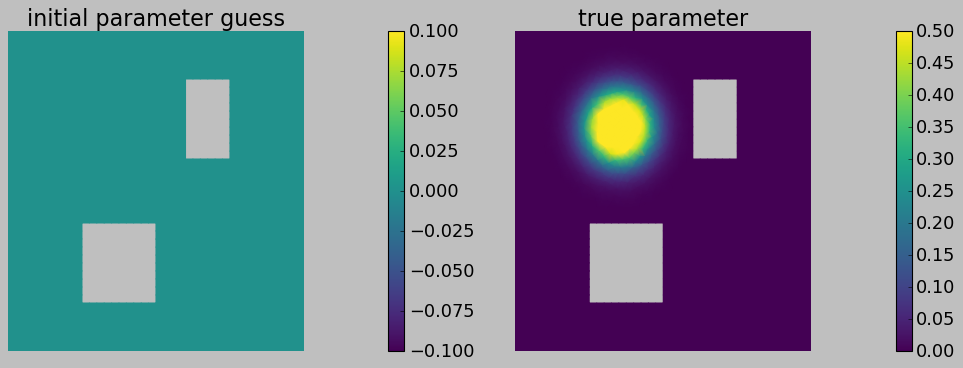

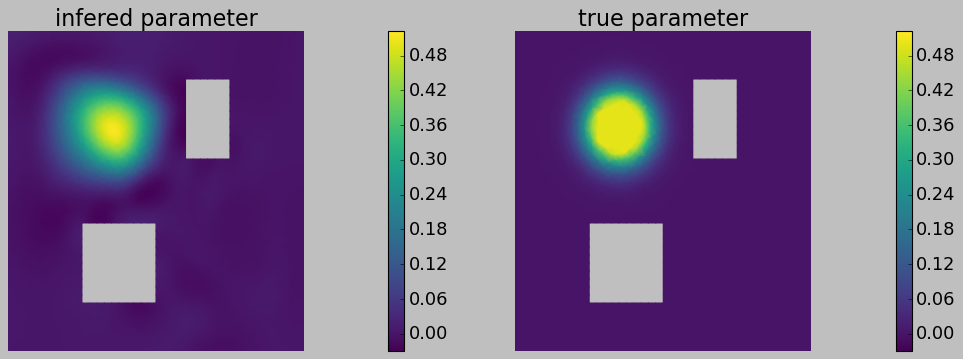

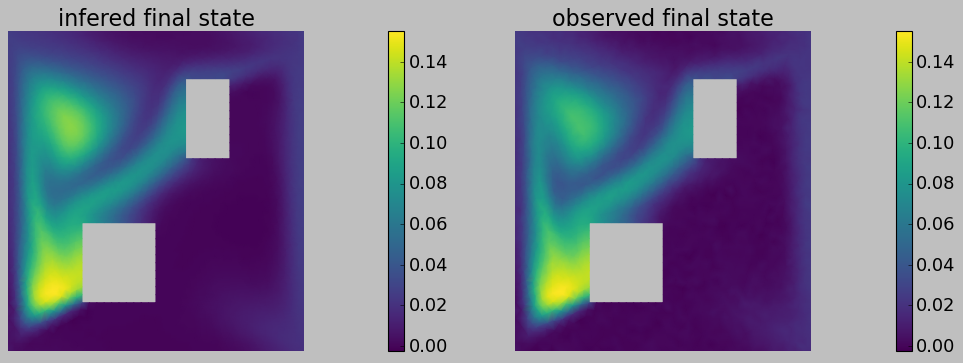

In [49]:
m0 = dl.interpolate(dl.Constant(0.0), Vh)
mh.assign(m0)
g = hess.grad(m0)

solver = CGSolverSteihaug()
solver.set_operator(hess)
precond_solver = dl.LUSolver()
precond_solver.set_operator(hess.M)
# precond_solver.set_operator(hess.R)
solver.set_preconditioner(precond_solver)
solver.parameters["print_level"]= 0
solver.solve(mh.vector(), -1.*g)

mh.vector().axpy(1.0, m0.vector())
nb.multi1_plot([m0, mtrue], ["initial parameter guess", "true parameter"], same_colorbar=False)
plt.show()
nb.multi1_plot([mh, mtrue], ["infered parameter", "true parameter"])
plt.show()

uh = hess.solve_fwd(mh)

nb.multi1_plot([uh[-1], ud[-1]], ["infered final state", "observed final state"])


Copyright &copy; 2016-2021, The University of Texas at Austin & University of California, Merced.
All Rights reserved.
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.